In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_style('whitegrid')

In [106]:
import numpy as np
import tensorflow as tf

import sklearn
import sklearn.decomposition
import scipy

In [301]:
import pathlib
import plot_export

export_path = pathlib.Path('export', 'polynoms')

In [303]:
XY_true = np.array([
    [-2., -3.],
    [-1., 0.5],
    [0., -0.5],
    [1., 2.],
    [2., 5.],
])
true_function = scipy.interpolate.lagrange(*XY_true.T)

plot_export.to_text(
    export_path / 'true_observations.dat',
    XY_true.T,
    ['X', 'Y'],
)

# def true_function(x):
    # return 0.2 * x ** 3 + x ** 2 - 0.5 * x
    # return 0.1 * (x + 1.25) ** 2 * (x + .5) * (x - .5) ** 2

def noise(x):
    return np.random.RandomState(42).normal(scale=1., size=x.shape)

In [304]:
X = np.array([
    -2.,
    -1.8,
    -1.3,
    -1.,
    -0.8,
    -0.1,
    0.3,
    1.,
    1.2,
    1.8,
    2.,
])[..., None]
Y = true_function(X)
E = noise(X)

plot_export.to_text(
    export_path / 'training_data.dat',
    [X, Y, E, Y + E],
    ['X', 'Ytrue', 'noise', 'Y'],
)

Xt = np.mgrid[-2.5:2.5:100j][..., None]
Yt = true_function(Xt)


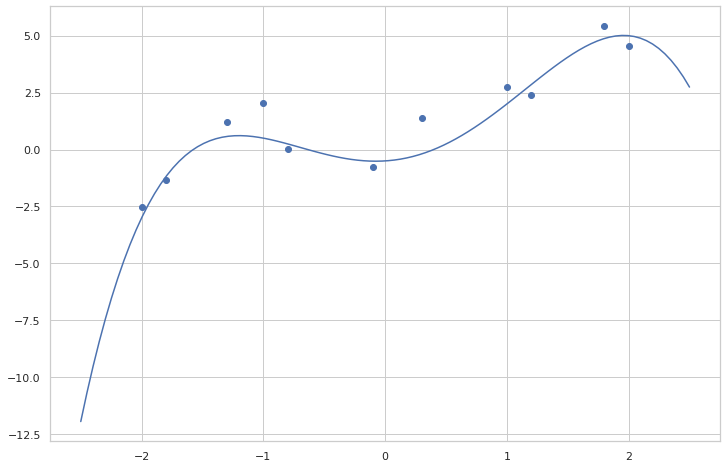

In [275]:
plt.plot(Xt, Yt)
plt.scatter(X, Y + E)

In [276]:
lagrange = scipy.interpolate.lagrange(X[..., 0], Y[..., 0] + E[..., 0])
Yt_lagrange = lagrange(Xt[..., 0])[..., None]

lagrange.coefficients

array([ -0.58545902,   0.15246393,   5.47373838,  -1.87008271,
       -17.0789586 ,   7.86473132,  19.4880671 , -12.54876589,
        -4.86796929,   6.77385579,  -0.03418627])

In [277]:
PCA = sklearn.decomposition.PCA(n_components=2).fit(np.concatenate([X, Y], axis=-1))

first_component = PCA.components_[..., 0] 
scale = first_component[1] / first_component[0]
shift = PCA.mean_[1] - scale * PCA.mean_[0]

Yt_PCA = scale * Xt + shift

In [284]:
LS = sklearn.linear_model.LinearRegression().fit(X, Y)
Yt_LS = LS.predict(Xt)

In [295]:
LS_dual = sklearn.linear_model.LinearRegression().fit(Y, X)
Yt_LS_dual = 1. / LS_dual.coef_ * Xt - LS_dual.intercept_ / LS_dual.coef_

In [291]:
quad = sklearn.preprocessing.PolynomialFeatures(2).fit(X)
Quad_LS = sklearn.linear_model.LinearRegression().fit(quad.transform(X), Y)

Yt_Quad_LS = Quad_LS.predict(quad.transform(Xt))

In [292]:
cube = sklearn.preprocessing.PolynomialFeatures(3).fit(X)
Cube_LS = sklearn.linear_model.LinearRegression().fit(cube.transform(X), Y)

Yt_Cube_LS = Cube_LS.predict(cube.transform(Xt))

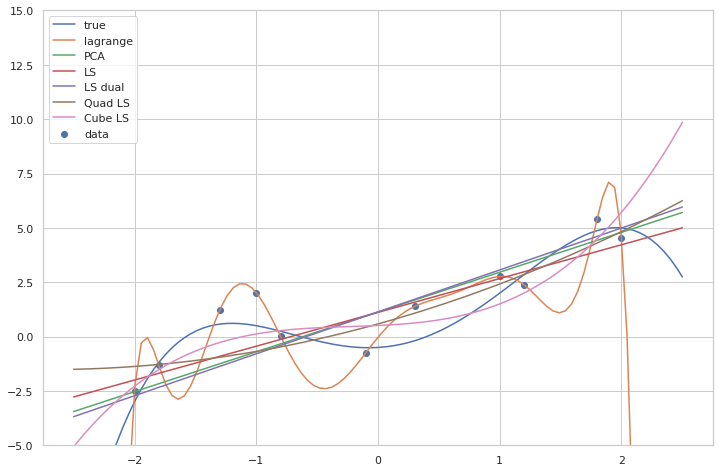

In [296]:
plt.plot(
    Xt,
    Yt,
    label='true'
)

plt.plot(
    Xt,
    Yt_lagrange,
    label='lagrange'
)

plt.plot(
    Xt,
    Yt_PCA,
    label='PCA'
)

plt.plot(
    Xt,
    Yt_LS,
    label='LS'
)

plt.plot(
    Xt,
    Yt_LS_dual,
    label='LS dual'
)

plt.plot(
    Xt,
    Yt_Quad_LS,
    label='Quad LS'
)

plt.plot(
    Xt,
    Yt_Cube_LS,
    label='Cube LS'
)

plt.scatter(
    X,
    Y + E,
    label='data'
)

plt.ylim(-5., 15.)
plt.legend()

In [305]:
plot_export.to_text(
    export_path / 'test_data.dat',
    [Xt, Yt, Yt_lagrange, Yt_PCA, Yt_LS, Yt_LS_dual, Yt_Quad_LS, Yt_Cube_LS],
    ['X', 'true', 'lagrange', 'PCA', 'LS', 'LSdual', 'QuadLS', 'CubeLS'],
)